# 🧠 Segmentação de Tumores Cerebrais com BraTS2020

**Objetivo do Projeto:** Desenvolver um pipeline completo de Deep Learning para segmentar tumores cerebrais a partir de imagens de ressonância magnética (MRI) do dataset BraTS2020.

**Fases do Pipeline:**
1.  **Configuração e Análise:** Preparação do ambiente, organização dos dados e análise exploratória.
2.  **Modelagem e Treinamento:** Implementação do modelo U-Net 3D, funções de perda e treinamento.
3.  **Validação e Inferência:** Avaliação do modelo e aplicação em novos dados.

---

###  Índice de Navegação

Navegue facilmente pelas seções do projeto clicando nos links abaixo.

#### Fase 1: Preparação e Análise
1. [Configuração do Ambiente](#configuracao)
2. [Organização e Divisão dos Dados](#organizacao-dados)
3. [Análise Exploratória e Seleção de Modalidades](#analise-exploratoria)
4. [Pipeline de Pré-processamento](#preprocessamento)

#### Fase 2: Modelagem e Treinamento
5. [Dataset e DataLoader](#dataset-loader)
6. [Modelo, Perda e Métricas](#modelo-perda-metricas)
7. [Treinamento e Validação](#treinamento)

#### Fase 3: Resultados e Inferência
8. [Análise de Resultados e Inferência](#resultados)

---

<a id="configuracao"></a>

## 1. Configuração do Ambiente

Nesta seção, vamos importar as bibliotecas essenciais e definir as configurações iniciais do projeto.

In [1]:
# Imports principais
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nibabel as nib
import os
import glob
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom
from torch.utils.data import Dataset, DataLoader
import tqdm
from typing import Dict, Union, Tuple


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#  Configurações do Projeto
TRAIN_DATASET_PATH = '/content/drive/MyDrive/dataset/BraTS2020_TrainingData'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData'
TARGET_SIZE = (128, 128, 64) #(H, W, D) Dimensões finais do volume 3D após o pré-processamento

<a id="organizacao-dados"></a>

## 2. Organização e Divisão dos Dados

O primeiro passo é estruturar os caminhos para cada arquivo do dataset BraTS2020.
Em seguida, dividimos os dados de forma aleatória e estratificada para garantir que nosso modelo seja treinado e validado de forma robusta.

**Divisão dos Dados:**
- **Treino:** 68% dos pacientes
- **Validação:** 20% dos pacientes
- **Teste:** 12% dos pacientes

In [6]:
def organize_patients_from_folders(data_dir):
    """Organiza pacientes de forma simples e direta"""
    patients = {}

    # Buscar todas as pastas BraTS20
    pattern = os.path.join(data_dir, "**", "BraTS20*")
    patient_dirs = glob.glob(pattern, recursive=True)

    for patient_path in patient_dirs:
        if os.path.isdir(patient_path):
            patient_id = os.path.basename(patient_path)
            patients[patient_id] = {}

            # Buscar arquivos .nii na pasta do paciente
            for file in os.listdir(patient_path):
                if file.endswith('.nii'):
                    file_path = os.path.join(patient_path, file)
                    file_lower = file.lower()

                    if 'flair' in file_lower:
                        patients[patient_id]['flair'] = file_path
                    elif 't1ce' in file_lower:
                        patients[patient_id]['t1ce'] = file_path
                    elif 't1' in file_lower and 't1ce' not in file_lower:
                        patients[patient_id]['t1'] = file_path
                    elif 't2' in file_lower:
                        patients[patient_id]['t2'] = file_path
                    elif 'seg' in file_lower:
                        patients[patient_id]['seg'] = file_path

    return patients

def create_training_splits(data_dir):
    """Divisão  usando APENAS TrainingData"""

    # 1. Carregar APENAS dados de training
    train_patients_data = organize_patients_from_folders(data_dir)

    # 3. Divisão hierárquica com sklearn
    all_patients = list(train_patients_data.keys())

    print(f" Dataset: {len(all_patients)} pacientes do TrainingData")

    # Primeira divisão: separar validação (20%)
    train_and_test_ids, val_ids = train_test_split(
        all_patients,
        test_size=0.2,  # 20% para validação
        random_state=42,
        shuffle=True
    )

    # Segunda divisão: separar treino e teste (15% do restante)
    train_ids, test_ids = train_test_split(
        train_and_test_ids,
        test_size=0.15,  # 15% do 80% restante = ~12% total
        random_state=42,
        shuffle=True
    )

    print(f" Divisão realizada:")
    print(f"    Treino: {len(train_ids)} pacientes ({len(train_ids)/len(all_patients)*100:.1f}%)")
    print(f"    Validação: {len(val_ids)} pacientes ({len(val_ids)/len(all_patients)*100:.1f}%)")
    print(f"    Teste: {len(test_ids)} pacientes ({len(test_ids)/len(all_patients)*100:.1f}%)")

    return train_patients_data, train_ids, val_ids, test_ids

In [7]:
# Carregar e dividir dados
train_patients_data, train_patients, val_patients, test_patients = create_training_splits(TRAIN_DATASET_PATH)

# Verificar exemplo de paciente
if train_patients:
    example_patient = train_patients[0]
    example_files = train_patients_data[example_patient]
    print(f"\n **Exemplo - {example_patient}:**")
    for modality, file_path in example_files.items():
        print(f"   {modality}: {'-OK' if os.path.exists(file_path) else 'Erro'}")

 Dataset: 369 pacientes do TrainingData
 Divisão realizada:
    Treino: 250 pacientes (67.8%)
    Validação: 74 pacientes (20.1%)
    Teste: 45 pacientes (12.2%)

 **Exemplo - BraTS20_Training_254:**
   t1ce: ✅
   seg: ✅
   flair: ✅
   t1: ✅
   t2: ✅


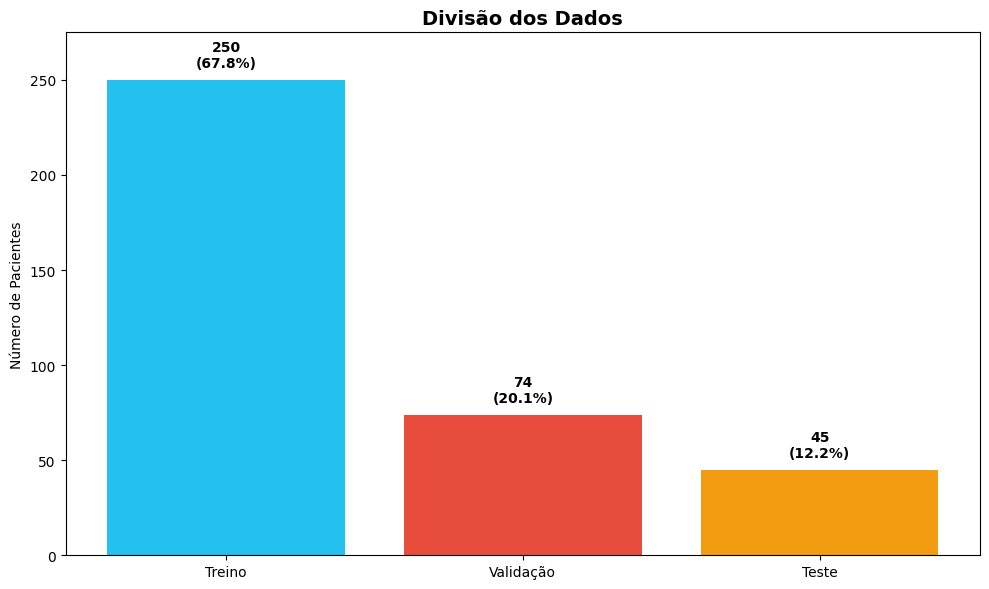

In [8]:
# Dados para visualização
division_data = [
    ('Treino', len(train_patients)),
    ('Validação', len(val_patients)),
    ('Teste', len(test_patients))
]

# Ordenar por quantidade
division_data.sort(key=lambda x: x[1], reverse=True)
labels = [item[0] for item in division_data]
counts = [item[1] for item in division_data]
percentages = [count/sum(counts)*100 for count in counts]

# Criar gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de barras
colors = ["#23c2ee", '#e74c3c', '#f39c12']
bars = ax.bar(labels, counts, color=colors)
ax.set_title('Divisão dos Dados', fontsize=14, fontweight='bold')
ax.set_ylabel('Número de Pacientes')

# Adicionar valores nas barras
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    ax.text(i, count + 5, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Adicionar grid para melhor visualização
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(counts) * 1.1)

plt.grid(False)
plt.tight_layout()
plt.show()


<a id="analise-exploratoria"></a>

## 3. Análise Exploratória e Seleção de Modalidades

Antes do pré-processamento, é crucial entender as características das imagens de ressonância magnética.

In [9]:
## Implementação das Funções de Pré-processamento
# - apply_minmax_scaler: Normaliza intensidades de voxel para escala [0, 1]
# - remap_labels: Reatribui rótulos da máscara para sequência contínua (0,1,2,4 → 0,1,2,3)
# - combine_modalities: Combina modalidades selecionadas em volume multicanal normalizado

def apply_minmax_scaler(image_data):
    """Aplica Min-Max scaling em uma imagem 3D"""
    original_shape = image_data.shape
    image_flat = image_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    image_scaled = scaler.fit_transform(image_flat)
    return image_scaled.reshape(original_shape)

def remap_labels(mask_data):
    """Reatribui rótulos para serem contínuos: 0,1,2,4 -> 0,1,2,3"""
    mask_remapped = mask_data.copy()
    mask_remapped[mask_data == 4] = 3
    return mask_remapped

def combine_modalities(patient_files, selected_modalities=None):
    """Combina modalidades selecionadas em um volume multicanal"""
    if selected_modalities is None:
        selected_modalities = ['t1', 't1ce', 't2']  # Default: 3 modalidades

    combined_channels = []

    for modality in selected_modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            data_normalized = apply_minmax_scaler(data)
            combined_channels.append(data_normalized)

    if combined_channels:
        combined_volume = np.stack(combined_channels, axis=-1)
        return combined_volume
    return None


In [10]:
## Implementação das Funções de Análise de Modalidades Brutas
# - analyze_raw_modalities: Carrega e analisa dados das modalidades sem normalização
# - visualize_raw_modalities: Visualiza modalidades brutas com overlay de máscara
# - analyze_mask_labels: Analisa distribuição dos rótulos da máscara original

def analyze_raw_modalities(patient_files):
    """Analisa modalidades brutas antes da normalização"""
    modalities = ['t1', 't1ce', 't2', 'flair']
    raw_data = {}

    for modality in modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            raw_data[modality] = data

            # Análise básica
            brain_mask = data > 0  # Máscara simples para região do cérebro
            brain_voxels = data[brain_mask]
            background_percentage = (np.sum(data == 0) / data.size) * 100

            print(f"\n{modality.upper()}:")
            print(f"   Shape: {data.shape}")
            print(f"   Min: {data.min():.2f}, Max: {data.max():.2f}, Mean: {data.mean():.2f}")
            if len(brain_voxels) > 0:
                print(f"   Brain Mean: {brain_voxels.mean():.2f}")
            print(f"   Background: {background_percentage:.1f}%")

def visualize_raw_modalities(patient_files, mask_data=None, slice_idx=None):
    """Visualiza modalidades brutas com máscara opcional"""
    # Carregar dados das modalidades
    modalities = ['t1', 't1ce', 't2', 'flair']
    raw_data = {}

    for modality in modalities:
        if modality in patient_files:
            raw_data[modality] = nib.load(patient_files[modality]).get_fdata()

    if not raw_data:
        print("❌ Nenhuma modalidade encontrada")
        return

    # Se máscara não foi fornecida, tentar carregar
    if mask_data is None and 'seg' in patient_files:
        mask_data = nib.load(patient_files['seg']).get_fdata()

    # Usar as modalidades DISPONÍVEIS
    modalities_available = list(raw_data.keys())
    n_modalities = len(modalities_available)

    # Usar modalidades disponíveis para obter shape
    if slice_idx is None:
        slice_idx = raw_data[modalities_available[0]].shape[2] // 2

    fig, axes = plt.subplots(2, n_modalities, figsize=(20, 8))
    if n_modalities == 1:
        axes = axes.reshape(2, 1)

    # Primeira linha: modalidades brutas
    for i, modality in enumerate(modalities_available):
        data = raw_data[modality]
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Bruto')
        axes[0, i].axis('off')

    # Segunda linha: modalidades com overlay da máscara (se disponível)
    for i, modality in enumerate(modalities_available):
        data = raw_data[modality]
        axes[1, i].imshow(data[:, :, slice_idx], cmap='gray')

        if mask_data is not None:
            # Overlay da máscara
            mask_slice = mask_data[:, :, slice_idx]
            masked_overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
            axes[1, i].imshow(masked_overlay, cmap='viridis', alpha=0.3)
            axes[1, i].set_title(f'{modality.upper()} + Máscara')
        else:
            axes[1, i].set_title(f'{modality.upper()} - Sem Máscara')
        axes[1, i].axis('off')

    plt.suptitle(f'Modalidades Brutas - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

def analyze_mask_labels(mask_data):
    """Analisa os rótulos da máscara original"""
    unique_labels = np.unique(mask_data)

    print(f"\nANÁLISE DA MÁSCARA:")
    print(f"   Rótulos únicos: {unique_labels}")
    print(f"   Distribuição:")

    for label in unique_labels:
        count = np.sum(mask_data == label)
        percentage = (count / mask_data.size) * 100

        label_name = {
            0: "Fundo",
            1: "NCR/NET (Necrose)",
            2: "Edema",
            4: "Tumor Realçante"
        }.get(label, f"Desconhecido ({label})")

        print(f"     {label}: {label_name} - {count:,} voxels ({percentage:.2f}%)")

    return unique_labels

In [11]:
# Implementação das funções para análise de contraste e seleção de modalidades:
# - analyze_contrast_tumor_separation(): Calcula métricas de contraste entre regiões tumorais e fundo
# - select_best_modalities(): Seleciona as melhores modalidades baseada em scores de contraste
# - visualize_contrast_comparison(): Visualiza comparação de contraste entre modalidades


def analyze_contrast_tumor_separation(patient_files):
    """
    Analisa o contraste entre diferentes modalidades de MRI para separação de regiões tumorais.

    Calcula métricas de contraste entre diferentes regiões (fundo, tumor core, edema, realçante)
    para cada modalidade disponível. O contraste é calculado como a diferença normalizada
    entre as intensidades médias das regiões.

    Args:
        patient_files (dict): Dicionário contendo caminhos dos arquivos por modalidade
                             Deve incluir 'seg' para máscara e modalidades como 't1', 't1ce', etc.

    Returns:
        dict: Scores de contraste por modalidade contendo:
              - overall: Score geral de contraste
              - tumor_bg: Contraste tumor-fundo
              - enhancing_bg: Contraste realçante-fundo
              - edema_bg: Contraste edema-fundo
              - means: Médias por região
    """
    modalities = ['t1', 't1ce', 't2', 'flair']
    contrast_scores = {}

    # Carregar máscara primeiro
    if 'seg' not in patient_files:
        print("Máscara não disponível para análise de contraste")
        return {}

    mask_data = nib.load(patient_files['seg']).get_fdata()

    print(f"\nANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:")
    print("=" * 50)

    for modality in modalities:
        if modality not in patient_files:
            print(f"Modalidade {modality.upper()} não encontrada")
            continue

        # Carregar dados da modalidade
        data = nib.load(patient_files[modality]).get_fdata()

        # Extrair intensidades para diferentes regiões
        background = data[mask_data == 0]  # Fundo
        tumor_core = data[mask_data == 1]  # NCR/NET
        edema = data[mask_data == 2]       # Edema
        enhancing = data[mask_data == 4]   # Tumor realçante

        # Calcular médias das regiões (com verificação de existência)
        bg_mean = background.mean() if len(background) > 0 else 0
        tumor_mean = tumor_core.mean() if len(tumor_core) > 0 else 0
        edema_mean = edema.mean() if len(edema) > 0 else 0
        enh_mean = enhancing.mean() if len(enhancing) > 0 else 0

        # Calcular contrastes (diferenças normalizadas)
        contrast_tumor_bg = abs(tumor_mean - bg_mean) / (tumor_mean + bg_mean + 1e-8)
        contrast_enh_bg = abs(enh_mean - bg_mean) / (enh_mean + bg_mean + 1e-8)
        contrast_edema_bg = abs(edema_mean - bg_mean) / (edema_mean + bg_mean + 1e-8)

        # Score geral (média ponderada dos contrastes)
        overall_contrast = (contrast_tumor_bg + contrast_enh_bg + contrast_edema_bg) / 3

        contrast_scores[modality] = {
            'overall': overall_contrast,
            'tumor_bg': contrast_tumor_bg,
            'enhancing_bg': contrast_enh_bg,
            'edema_bg': contrast_edema_bg,
            'means': {
                'background': bg_mean,
                'tumor_core': tumor_mean,
                'edema': edema_mean,
                'enhancing': enh_mean
            }
        }

        print(f"\n{modality.upper()}:")
        print(f"   Médias por região:")
        print(f"     Fundo: {bg_mean:.2f}")
        print(f"     Tumor Core: {tumor_mean:.2f}")
        print(f"     Edema: {edema_mean:.2f}")
        print(f"     Realçante: {enh_mean:.2f}")
        print(f"   Contrastes:")
        print(f"     Tumor-Fundo: {contrast_tumor_bg:.3f}")
        print(f"     Realçante-Fundo: {contrast_enh_bg:.3f}")
        print(f"     Edema-Fundo: {contrast_edema_bg:.3f}")
        print(f"   Score Geral: {overall_contrast:.3f}")

    return contrast_scores

def select_best_modalities(contrast_scores, n_best=3):
    """
    Seleciona as melhores modalidades baseado nos scores de contraste.

    Args:
        contrast_scores (dict): Scores de contraste por modalidade
        n_best (int): Número de modalidades a selecionar

    Returns:
        list: Lista das melhores modalidades ordenadas por score
    """
    # Ordenar por score geral em ordem decrescente
    sorted_modalities = sorted(contrast_scores.items(),
                              key=lambda x: x[1]['overall'],
                              reverse=True)

    best_modalities = [mod[0] for mod in sorted_modalities[:n_best]]

    print(f"\nRANKING DE MODALIDADES (por contraste):")
    print("=" * 40)
    for i, (modality, scores) in enumerate(sorted_modalities, 1):
        status = "SELECIONADA" if modality in best_modalities else "Não selecionada"
        print(f"{i}. {modality.upper()}: {scores['overall']:.3f} - {status}")

    print(f"\nMODALIDADES SELECIONADAS: {[mod.upper() for mod in best_modalities]}")
    return best_modalities

def visualize_contrast_comparison(patient_files, slice_idx=None):
    """
    Visualiza comparação de contraste entre modalidades em uma fatia específica.

    Exibe as modalidades disponíveis em duas linhas: imagem original e com realce
    nas regiões tumorais para facilitar comparação visual do contraste.

    Args:
        patient_files (dict): Dicionário com caminhos dos arquivos por modalidade
        slice_idx (int, optional): Índice da fatia a visualizar. Se None, usa fatia central.
    """
    modalities = ['t1', 't1ce', 't2', 'flair']
    available_modalities = [mod for mod in modalities if mod in patient_files]

    if not available_modalities:
        print("Nenhuma modalidade encontrada")
        return

    # Carregar máscara
    if 'seg' not in patient_files:
        print("Máscara não disponível para visualização")
        mask_data = None
    else:
        mask_data = nib.load(patient_files['seg']).get_fdata()

    # Carregar primeira modalidade para obter slice central
    first_data = nib.load(patient_files[available_modalities[0]]).get_fdata()
    if slice_idx is None:
        slice_idx = first_data.shape[2] // 2

    fig, axes = plt.subplots(2, len(available_modalities), figsize=(20, 8))
    if len(available_modalities) == 1:
        axes = axes.reshape(2, 1)

    for i, modality in enumerate(available_modalities):
        # Carregar dados da modalidade
        data = nib.load(patient_files[modality]).get_fdata()

        # Imagem original
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Original')
        axes[0, i].axis('off')

        # Imagem com realce nas regiões de tumor
        if mask_data is not None:
            tumor_regions = (mask_data[:, :, slice_idx] > 0)
            enhanced_data = data[:, :, slice_idx].copy()
            enhanced_data[tumor_regions] = enhanced_data[tumor_regions] * 1.5  # Realçar tumor

            axes[1, i].imshow(enhanced_data, cmap='hot')
            axes[1, i].set_title(f'{modality.upper()} - Tumor Realçado')
        else:
            axes[1, i].imshow(data[:, :, slice_idx], cmap='gray')
            axes[1, i].set_title(f'{modality.upper()} - Sem Máscara')

        axes[1, i].axis('off')

    plt.suptitle(f'Comparação de Contraste - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

### 3.1. Visualização das Modalidades

Analisamos as quatro modalidades de MRI disponíveis (T1, T1ce, T2, FLAIR) para um paciente exemplo, observando a distribuição de intensidade dos voxels e a aparência do tumor em cada uma.

* **Análise da Máscara:** Verificamos os rótulos de segmentação para entender as classes que o modelo deve aprender.


In [ ]:
first_patient = train_patients[0]  # Primeiro paciente do conjunto de TREINO
patient_files = train_patients_data[first_patient]

In [ ]:
print(f"{first_patient}")

BraTS20_Training_252



ANÁLISE DA MÁSCARA:
   Rótulos únicos: [0. 1. 2. 4.]
   Distribuição:
     0.0: Fundo - 8,723,758 voxels (97.71%)
     1.0: NCR/NET (Necrose) - 28,927 voxels (0.32%)
     2.0: Edema - 130,784 voxels (1.46%)
     4.0: Tumor Realçante - 44,531 voxels (0.50%)


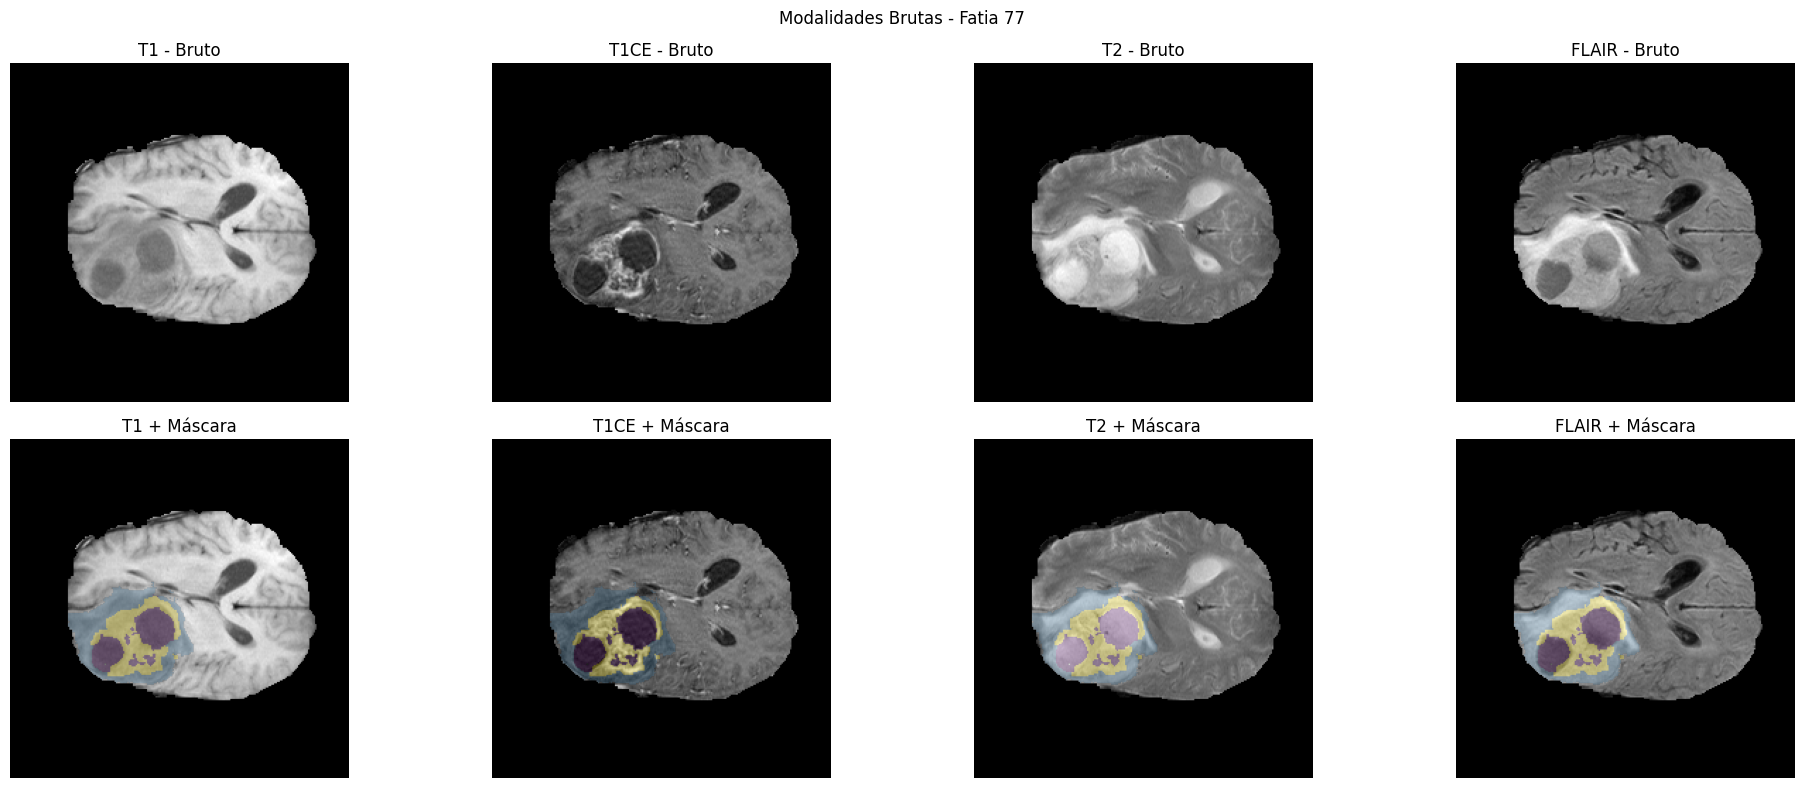

In [ ]:
# Carregar e analisar máscara
if 'seg' in patient_files:
    mask_data = nib.load(patient_files['seg']).get_fdata()
    unique_labels = analyze_mask_labels(mask_data)

    # Visualizar modalidades brutas com máscara
    visualize_raw_modalities(patient_files, mask_data)

else:
    print("Máscara não disponível para análise")
    mask_data = None


In [ ]:
print(f"ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: {first_patient}")

# Analisar modalidades brutas
analyze_raw_modalities(patient_files)

ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: BraTS20_Training_252

T1:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 1390.00, Mean: 76.38
   Brain Mean: 415.92
   Background: 81.6%

T1CE:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 519.00, Mean: 23.20
   Brain Mean: 126.31
   Background: 81.6%

T2:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 1082.00, Mean: 85.75
   Brain Mean: 468.57
   Background: 81.7%

FLAIR:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 1063.00, Mean: 78.08
   Brain Mean: 425.17
   Background: 81.6%


### 3.2. Seleção Automática de Modalidades por Contraste

Para otimizar o treinamento, implementamos uma análise quantitativa de contraste. As 3 modalidades que melhor separam as regiões tumorais do tecido saudável são selecionadas automaticamente para compor o volume de entrada do modelo.

In [ ]:
# Análise de contraste das modalidades para seleção automática
contrast_scores = analyze_contrast_tumor_separation(patient_files)



ANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:



T1:
   Médias por região:
     Fundo: 69.50
     Tumor Core: 312.89
     Edema: 385.35
     Realçante: 362.32
   Contrastes:
     Tumor-Fundo: 0.636
     Realçante-Fundo: 0.678
     Edema-Fundo: 0.694
   Score Geral: 0.670

T1CE:
   Médias por região:
     Fundo: 20.94
     Tumor Core: 79.96
     Edema: 109.98
     Realçante: 173.16
   Contrastes:
     Tumor-Fundo: 0.585
     Realçante-Fundo: 0.784
     Edema-Fundo: 0.680
   Score Geral: 0.683

T2:
   Médias por região:
     Fundo: 71.74
     Tumor Core: 778.78
     Edema: 663.89
     Realçante: 682.33
   Contrastes:
     Tumor-Fundo: 0.831
     Realçante-Fundo: 0.810
     Edema-Fundo: 0.805
   Score Geral: 0.815

FLAIR:
   Médias por região:
     Fundo: 65.04
     Tumor Core: 518.61
     Edema: 670.70
     Realçante: 605.11
   Contrastes:
     Tumor-Fundo: 0.777
     Realçante-Fundo: 0.806
     Edema-Fundo: 0.823
   Score Geral: 0.802



SELEÇÃO AUTOMÁTICA DAS MELHORES MODALIDADES:
Critério: Maior capacidade de separação entre regiões tumorais e tecido saudável

RANKING DE MODALIDADES (por contraste):
1. T2: 0.815 - SELECIONADA
2. FLAIR: 0.802 - SELECIONADA
3. T1CE: 0.683 - SELECIONADA
4. T1: 0.670 - Não selecionada

MODALIDADES SELECIONADAS: ['T2', 'FLAIR', 'T1CE']

COMPARAÇÃO VISUAL DE CONTRASTE:
Objetivo: Confirmar visualmente a qualidade das modalidades selecionadas


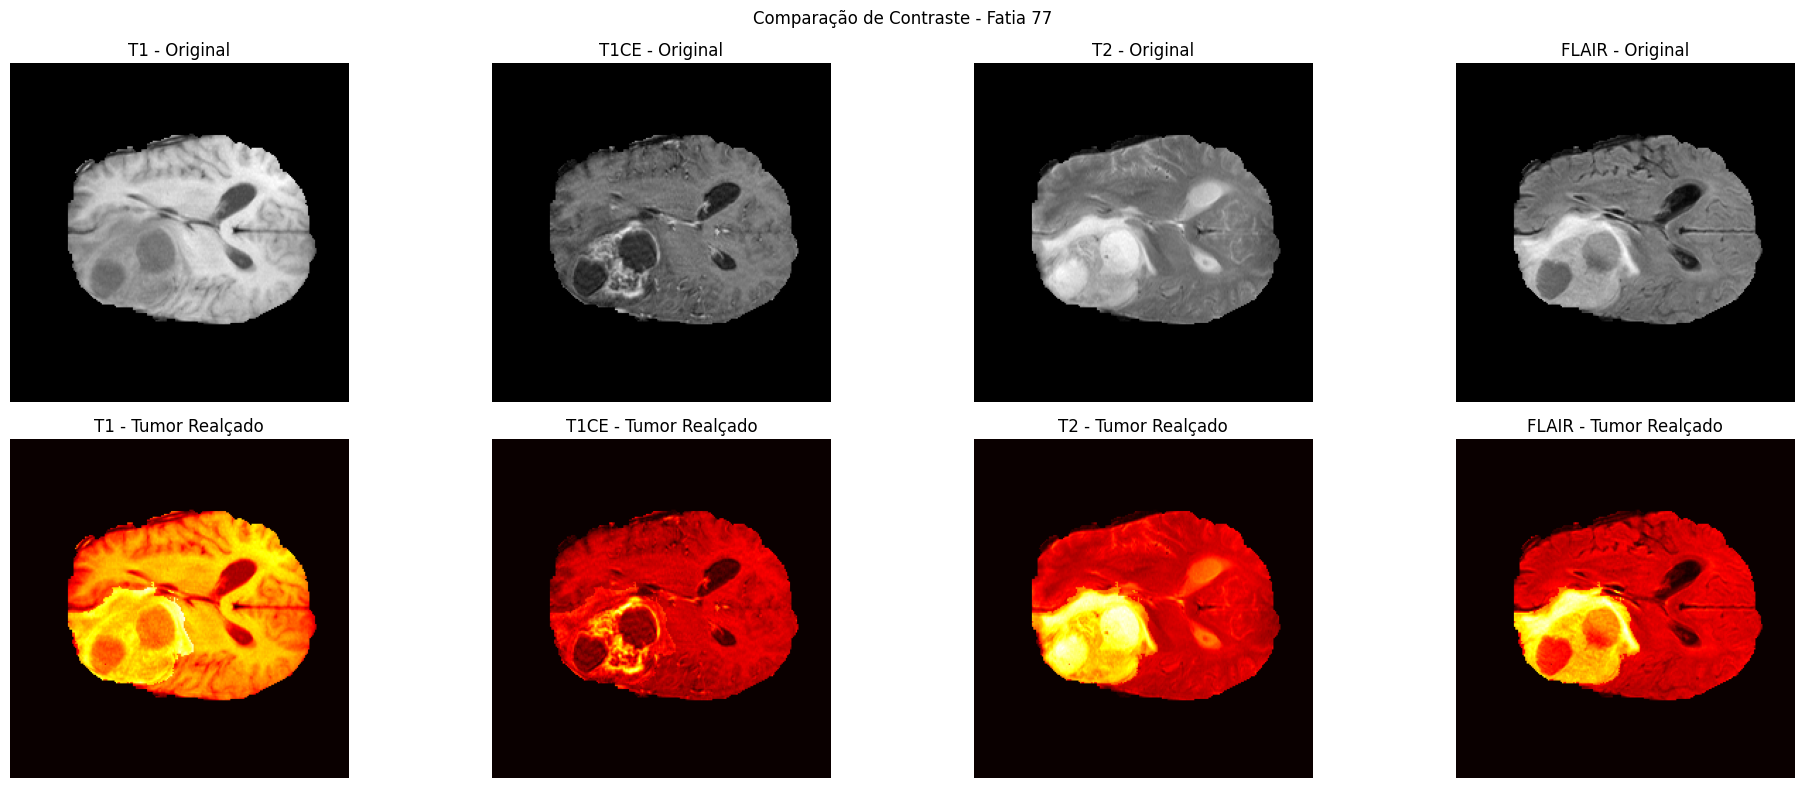

In [ ]:
#  Seleção automática das 3 melhores modalidades baseada em scores de contraste
print("\nSELEÇÃO AUTOMÁTICA DAS MELHORES MODALIDADES:")
print("Critério: Maior capacidade de separação entre regiões tumorais e tecido saudável")
best_modalities = select_best_modalities(contrast_scores, n_best=3)

# Visualização comparativa das modalidades para validação visual
print("\nCOMPARAÇÃO VISUAL DE CONTRASTE:")
print("Objetivo: Confirmar visualmente a qualidade das modalidades selecionadas")
visualize_contrast_comparison(patient_files)

<a id="preprocessamento"></a>

## 4. Pipeline de Pré-processamento

Com as modalidades selecionadas, aplicamos uma sequência de transformações para preparar os dados para o treinamento da rede neural.

**Etapas do Pipeline:**
1.  **Normalização Min-Max:** As intensidades de voxel de cada modalidade são normalizadas para a escala [0, 1].
2.  **Remapeamento da Máscara:** Os rótulos da máscara (0, 1, 2, 4) são remapeados para uma sequência contínua (0, 1, 2, 3) para compatibilidade com a função de perda.
3.  **Combinação de Modalidades:** As modalidades selecionadas são empilhadas para criar um volume 3D multicanal.
4.  **Redimensionamento Proporcional:** Os volumes são redimensionados para um tamanho fixo de `(128, 128, 64)`, preservando as proporções espaciais.

In [ ]:
def resize_volume_proportional(volume, mask, target_size=(128, 128, 64)):
    """
    Redimensiona volume preservando proporções para dimensões específicas

    Args:
        volume: Volume de entrada (H, W, D, C)
        mask: Máscara correspondente (H, W, D)
        target_size: Tamanho desejado (altura, largura, profundidade)

    Returns:
        volume_resized, mask_resized: Volumes redimensionados
    """

    # Calcular fatores de zoom para cada dimensão
    original_h, original_w, original_d = volume.shape[:3]
    target_h, target_w, target_d = target_size

    zoom_h = target_h / original_h
    zoom_w = target_w / original_w
    zoom_d = target_d / original_d

    # Redimensionar volume
    if volume.ndim == 4: # (C, H, W, D)
        volume_resized = np.zeros((target_h, target_w, target_d, volume.shape[3]))

        for channel in range(volume.shape[3]):
            volume_resized[:, :, :, channel] = zoom(
                volume[:, :, :, channel],
                (zoom_h, zoom_w, zoom_d),
                order=1  # Interpolação linear
            )
    else:  # (H, W, D)
        volume_resized = zoom(
            volume,
            (zoom_h, zoom_w, zoom_d),
            order=1
        )

    # Redimensionar máscara com interpolação nearest neighbor
    if mask is not None:
        mask_resized = zoom(
            mask,
            (zoom_h, zoom_w, zoom_d),
            order=0  # Interpolação nearest neighbor para labels
        )
    else:
        mask_resized = None

    return volume_resized, mask_resized

def visualize_resize_process(volume, mask, target_size=(128, 128, 64)):
    """
    Visualiza o processo de redimensionamento preservando proporções
    """

    # Aplicar redimensionamento
    volume_resized, mask_resized = resize_volume_proportional(volume, mask, target_size)

    # Visualizar comparação
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Calcular slice central
    original_slice = volume.shape[2] // 2
    resized_slice = volume_resized.shape[2] // 2

    # Primeira linha - Original
    axes[0, 0].imshow(volume[:, :, original_slice, 0], cmap='gray')
    axes[0, 0].set_title(f'Original - Modalidade 1\n{volume.shape[:3]}')
    axes[0, 0].axis('off')

    if volume.shape[3] > 1:
        axes[0, 1].imshow(volume[:, :, original_slice, 1], cmap='gray')
        axes[0, 1].set_title(f'Original - Modalidade 2\n{volume.shape[:3]}')
        axes[0, 1].axis('off')
    else:
        axes[0, 1].axis('off')

    if mask is not None:
        axes[0, 2].imshow(mask[:, :, original_slice], cmap='viridis')
        axes[0, 2].set_title(f'Máscara Original\n{mask.shape}')
        axes[0, 2].axis('off')

    # Segunda linha - Redimensionado
    axes[1, 0].imshow(volume_resized[:, :, resized_slice, 0], cmap='gray')
    axes[1, 0].set_title(f'Redimensionado - Modalidade 1\n{volume_resized.shape[:3]}')
    axes[1, 0].axis('off')

    if volume_resized.shape[3] > 1:
        axes[1, 1].imshow(volume_resized[:, :, resized_slice, 1], cmap='gray')
        axes[1, 1].set_title(f'Redimensionado - Modalidade 2\n{volume_resized.shape[:3]}')
        axes[1, 1].axis('off')
    else:
        axes[1, 1].axis('off')

    if mask_resized is not None:
        axes[1, 2].imshow(mask_resized[:, :, resized_slice], cmap='viridis')
        axes[1, 2].set_title(f'Máscara Redimensionada\n{mask_resized.shape}')
        axes[1, 2].axis('off')

    plt.suptitle('Comparação: Original vs Redimensionado (Proporções Preservadas)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return volume_resized, mask_resized

def analyze_resize_quality(volume_original, volume_resized, mask_original=None, mask_resized=None):
    """
    Analisa a qualidade do redimensionamento - versão simplificada
    """

    # Análise da preservação de intensidades
    for channel in range(volume_original.shape[3]):
        orig_channel = volume_original[:, :, :, channel]
        resized_channel = volume_resized[:, :, :, channel]

        orig_mean = orig_channel.mean()
        resized_mean = resized_channel.mean()
        diff_percent = abs(orig_mean - resized_mean) / orig_mean * 100

        print(f"Modalidade {channel + 1}:")
        print(f"  Original - Min: {orig_channel.min():.3f}, Max: {orig_channel.max():.3f}, Mean: {orig_mean:.3f}")
        print(f"  Redimensionado - Min: {resized_channel.min():.3f}, Max: {resized_channel.max():.3f}, Mean: {resized_mean:.3f}")
        print(f"  Diferença relativa: {diff_percent:.2f}%")

    # Estatísticas de redimensionamento
    original_volume = np.prod(volume_original.shape[:3])
    resized_volume = np.prod(volume_resized.shape[:3])
    reduction = (1 - (resized_volume / original_volume)) * 100
    compression = original_volume / resized_volume

    print(f"\nRedução de volume: {reduction:.1f}%")
    print(f"Fator de compressão: {compression:.2f}x")


TESTE DO PIPELINE COM REDIMENSIONAMENTO PROPORCIONAL
Paciente: BraTS20_Training_252
Modalidades: ['T2', 'FLAIR', 'T1CE']
--------------------------------------------------
Volume original: (240, 240, 155, 3)
Aplicando redimensionamento proporcional para (128, 128, 64)...


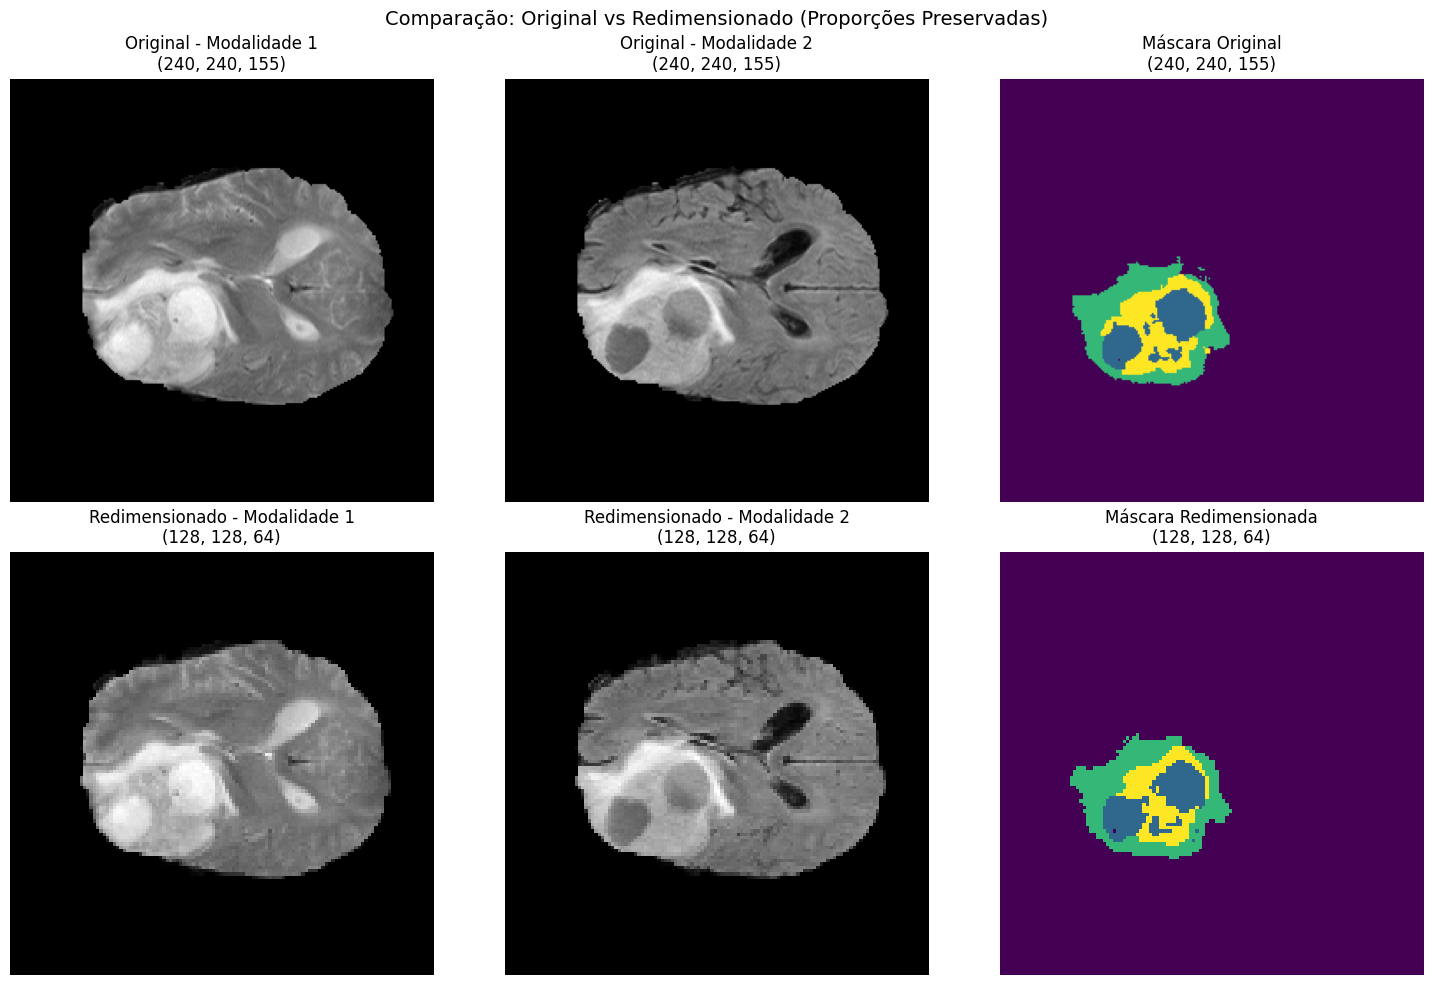

In [ ]:
# Teste do Pipeline com Modalidades Selecionadas e Redimensionamento
print("TESTE DO PIPELINE COM REDIMENSIONAMENTO PROPORCIONAL")
print(f"Paciente: {first_patient}")
print(f"Modalidades: {[mod.upper() for mod in best_modalities]}")
print("-" * 50)

# Processar dados com modalidades selecionadas
combined_volume = combine_modalities(patient_files, best_modalities)
mask = None
if 'seg' in patient_files:
    mask = nib.load(patient_files['seg']).get_fdata()
    mask = remap_labels(mask)

# Aplicar redimensionamento proporcional
if combined_volume is not None:
    print(f"Volume original: {combined_volume.shape}")
    print(f"Aplicando redimensionamento proporcional para {TARGET_SIZE}...")

    # Redimensionamento com análise visual
    volume_final, mask_final = visualize_resize_process(combined_volume, mask, TARGET_SIZE)

else:
    print("Erro: Volume combinado não pôde ser criado")

In [ ]:
analyze_resize_quality(combined_volume, volume_final, mask, mask_final)

Modalidade 1:
  Original - Min: 0.000, Max: 1.000, Mean: 0.079
  Redimensionado - Min: 0.000, Max: 0.894, Mean: 0.078
  Diferença relativa: 1.58%
Modalidade 2:
  Original - Min: 0.000, Max: 1.000, Mean: 0.073
  Redimensionado - Min: 0.000, Max: 0.870, Mean: 0.072
  Diferença relativa: 1.56%
Modalidade 3:
  Original - Min: 0.000, Max: 1.000, Mean: 0.045
  Redimensionado - Min: 0.000, Max: 0.782, Mean: 0.044
  Diferença relativa: 1.58%

Redução de volume: 88.3%
Fator de compressão: 8.51x


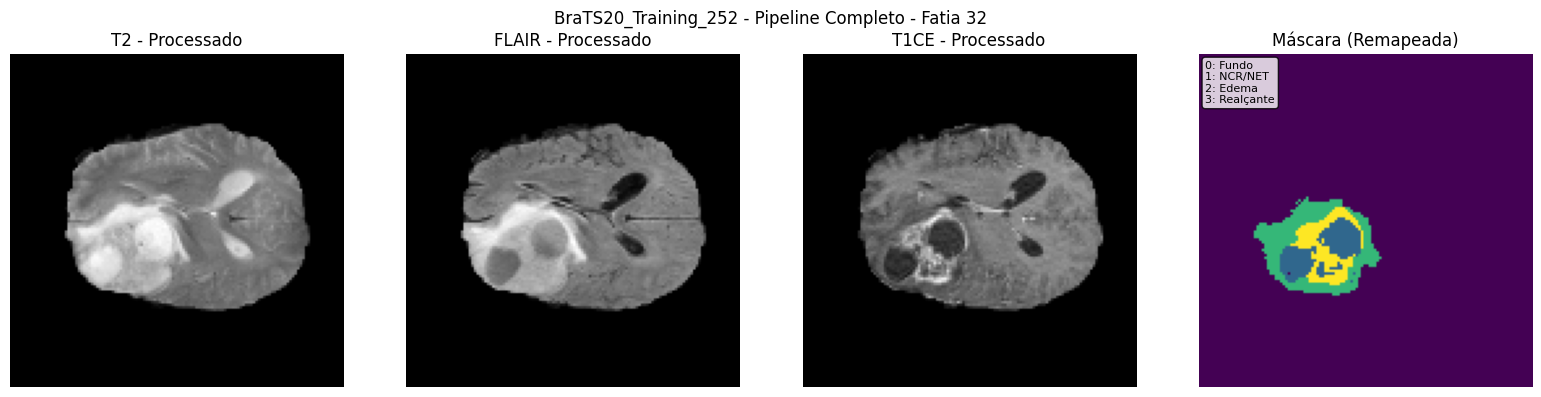


ESTATÍSTICAS FINAIS:
Volume processado: (128, 128, 64, 3)
Modalidades utilizadas: ['T2', 'FLAIR', 'T1CE']
Range de valores por modalidade:
  T2: [0.000, 0.894]
  FLAIR: [0.000, 0.870]
  T1CE: [0.000, 0.782]
Máscara: (128, 128, 64)
Distribuição de rótulos:
  0 (Fundo): 1,024,975 voxels (97.75%)
  1 (NCR/NET): 3,264 voxels (0.31%)
  2 (Edema): 15,153 voxels (1.45%)
  3 (Realçante): 5,184 voxels (0.49%)


In [ ]:
# Visualização do Resultado Final
if 'volume_final' in locals() and volume_final is not None:
    slice_idx = volume_final.shape[2] // 2

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Mostrar as 3 modalidades selecionadas
    selected_names = [mod.upper() for mod in best_modalities]

    for i in range(min(3, volume_final.shape[3])):
        axes[i].imshow(volume_final[:, :, slice_idx, i], cmap='gray')
        axes[i].set_title(f'{selected_names[i]} - Processado')
        axes[i].axis('off')

    # Máscara na última posição
    if mask_final is not None:
        axes[3].imshow(mask_final[:, :, slice_idx], cmap='viridis')
        axes[3].set_title('Máscara (Remapeada)')
        axes[3].axis('off')

        # Mostrar legenda dos rótulos
        unique_labels = np.unique(mask_final)
        legend_text = []
        for label in unique_labels:
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            legend_text.append(f"{int(label)}: {label_name.get(label, 'Desconhecido')}")

        axes[3].text(0.02, 0.98, '\n'.join(legend_text),
                    transform=axes[3].transAxes, fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.suptitle(f'{first_patient} - Pipeline Completo - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

    # Estatísticas finais
    print("\nESTATÍSTICAS FINAIS:")
    print(f"Volume processado: {volume_final.shape}")
    print(f"Modalidades utilizadas: {selected_names}")
    print(f"Range de valores por modalidade:")
    for i, name in enumerate(selected_names):
        channel_data = volume_final[:, :, :, i]
        print(f"  {name}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")

    if mask_final is not None:
        print(f"Máscara: {mask_final.shape}")
        print(f"Distribuição de rótulos:")
        for label in np.unique(mask_final):
            count = np.sum(mask_final == label)
            percentage = (count / mask_final.size) * 100
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            print(f"  {int(label)} ({label_name.get(label, 'Desconhecido')}): {count:,} voxels ({percentage:.2f}%)")

else:
    print("Não foi possível visualizar - dados não disponíveis")

<a id="dataset-loader"></a>

## 5. Dataset e DataLoader PyTorch

**Implementação do Dataset Customizado**

Esta seção implementa:
- **Dataset customizado** para BraTS2020
- **DataLoader** para treinamento
- **Tensores PyTorch** preparados para a U-Net 3D

In [ ]:
class BraTSDataset(Dataset):
    """Dataset para segmentação de tumores cerebrais BraTS"""

    def __init__(self, patient_ids, patients_data, selected_modalities=None, target_size=TARGET_SIZE):
        self.patient_ids = patient_ids
        self.patients_data = patients_data
        self.selected_modalities = selected_modalities or ['t2', 'flair', 't1ce']
        self.target_size = target_size

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_files = self.patients_data[patient_id]

        try:
            # Combinar modalidades selecionadas
            combined_volume = combine_modalities(patient_files, self.selected_modalities)

            # Processar máscara se disponível
            mask = None
            if 'seg' in patient_files:
                mask = nib.load(patient_files['seg']).get_fdata()
                mask = remap_labels(mask)

            # Aplicar redimensionamento proporcional
            if combined_volume is not None:
                volume_final, mask_final = resize_volume_proportional(combined_volume, mask, self.target_size)

                # Converter para tensores PyTorch
                volume_tensor = torch.from_numpy(volume_final).permute(3, 0, 1, 2).float()

                if mask_final is not None:
                    mask_tensor = torch.from_numpy(mask_final).long()
                else:
                    # Máscara vazia se não disponível
                    mask_tensor = torch.zeros(self.target_size, dtype=torch.long)

                return {
                    'volume': volume_tensor,
                    'mask': mask_tensor,
                    'patient_id': patient_id
                }
            else:
                raise ValueError(f"Não foi possível processar {patient_id}")

        except Exception as e:
            print(f"Erro ao processar {patient_id}: {e}")
            # Retornar tensores vazios em caso de erro
            return {
                'volume': torch.zeros((len(self.selected_modalities), *self.target_size)),
                'mask': torch.zeros(self.target_size, dtype=torch.long),
                'patient_id': patient_id
            }

In [ ]:
# Criar datasets com modalidades selecionadas
train_dataset = BraTSDataset(train_patients[:6], train_patients_data, best_modalities)
val_dataset = BraTSDataset(val_patients[:3], train_patients_data, best_modalities)

print("Dataset criado com modalidades selecionadas:")
print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
print(f"   Treino: {len(train_dataset)} pacientes")
print(f"   Validação: {len(val_dataset)} pacientes")

Dataset criado com modalidades selecionadas:
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Treino: 6 pacientes
   Validação: 3 pacientes


In [ ]:
# Criação dos DataLoaders
batch_size = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # 0 para evitar problemas no Windows
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
print("DataLoaders criados:")
print(f"   Treino: {len(train_loader)} batches de {batch_size}")
print(f"   Validação: {len(val_loader)} batches de {batch_size}")

# Testar um batch
try:
    batch = next(iter(train_loader))
    print(f"\nBatch de teste:")
    print(f"   Volume batch: {batch['volume'].shape}")  # (B, C, H, W, D)
    print(f"   Máscara batch: {batch['mask'].shape}")   # (B, H, W, D)
    print(f"   Pacientes: {batch['patient_id']}")
    print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
    print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

    # Estatísticas do batch
    print(f"\nEstatísticas do batch:")
    for i, mod in enumerate(best_modalities):
        channel_data = batch['volume'][:, i]
        print(f"   {mod.upper()}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")

    unique_labels = torch.unique(batch['mask'])
    print(f"   Rótulos únicos: {unique_labels.tolist()}")

except Exception as e:
    print(f"Erro ao testar batch: {e}")

DataLoaders criados:
   Treino: 3 batches de 2
   Validação: 2 batches de 2

Batch de teste:
   Volume batch: torch.Size([2, 3, 128, 128, 64])
   Máscara batch: torch.Size([2, 128, 128, 64])
   Pacientes: ['BraTS20_Training_070', 'BraTS20_Training_067']
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Device: CUDA

Estatísticas do batch:
   T2: [0.000, 0.872]
   FLAIR: [0.000, 0.934]
   T1CE: [0.000, 0.951]
   Rótulos únicos: [0, 1, 2, 3]


<a id="modelo-perda-metricas"></a>

## 6. Modelo, Perda e Métricas
Nesta seção, definimos os três pilares do nosso processo de aprendizado: a arquitetura do modelo, a função de Loss e as métricas que usarão para avaliá-lo.

###  Modelo U-Net 3D

## Arquitetura de Segmentação

*Esta seção implementará o modelo U-Net 3D para segmentação de tumores cerebrais*

### Componentes Planejados:
- **Encoder**: Contractive path com convoluções 3D
- **Decoder**: Expansive path com skip connections
- **Loss Function**: Dice Loss + CrossEntropy
- **Métricas**: Dice Score, Sensitivity/Specificity

### Especificações Técnicas:
- **Input**: (B, 3, 128, 128, 64) - 3 modalidades selecionadas
- **Output**: (B, 4, 128, 128, 64) - 4 classes de segmentação
- **Ativação**: LeakyReLU para camadas internas, Softmax para saída

In [ ]:
## Unet 3d com LeakyReLU
class DoubleConv3D(nn.Module):
    """(Conv3D -> GroupNorm -> LeakyReLU) * 2 - Otimi encoder/decoder"""
    def __init__(self, in_channels, out_channels, num_groups=8, is_encoder=True):
        super().__init__()

        # Escolher ativação baseada na posição (encoder vs decoder)
        if is_encoder:
            activation = nn.LeakyReLU(0.01, inplace=True)
        else:
            activation = nn.LeakyReLU(0.2, inplace=True)

        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation,

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation
        )

    def forward(self, x):
        return self.double_conv(x)

class Down3D(nn.Module):
    """Downscaling com MaxPool3D e DoubleConv3D - Encoder"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv3D(in_channels, out_channels, is_encoder=True)  # Encoder usa LeakyReLU(0.01)
        )

    def forward(self, x):
        return self.encoder(x)


class Up3D(nn.Module):
    """Upscaling com ConvTranspose3D e DoubleConv3D - Decoder"""
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)  # Decoder usa LeakyReLU(0.2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)  # Decoder usa LeakyReLU(0.2)


    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Ajuste de dimensões para concatenação
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2,
                       diffZ // 2, diffZ - diffZ // 2])

        # Concatenar ao longo da dimensão de canais
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv3D(nn.Module):
    """Camada de saída com Conv3D 1x1x1"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    """U-Net 3D para segmentação de tumores cerebrais"""
    def __init__(self, in_channels=3, n_classes=4, n_channels=24):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        # Encoder - usa LeakyReLU(0.01)
        self.input_conv = DoubleConv3D(in_channels, n_channels, is_encoder=True)
        self.down1 = Down3D(n_channels, 2 * n_channels)
        self.down2 = Down3D(2 * n_channels, 4 * n_channels)
        self.down3 = Down3D(4 * n_channels, 8 * n_channels)
        self.down4 = Down3D(8 * n_channels, 8 * n_channels)

        # Decoder - usa LeakyReLU(0.2)
        self.up1 = Up3D(16 * n_channels, 4 * n_channels)
        self.up2 = Up3D(8 * n_channels, 2 * n_channels)
        self.up3 = Up3D(4 * n_channels, n_channels)
        self.up4 = Up3D(2 * n_channels, n_channels)

        # saída
        self.output_conv = OutConv3D(n_channels, n_classes)


    def forward(self, x):
        # Encoder
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder com skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Saída
        logits = self.output_conv(x)
        return logits




In [ ]:
model = UNet3D(in_channels=3, n_classes=4, n_channels=24)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Devide: {device}")

Devide: cuda


In [ ]:
def print_detailed_architecture(model, input_shape=(1, 3, 128, 128, 64)):
    """
    Imprime apenas o detalhamento da arquitetura da U-Net 3D
    """

    total_params = sum(p.numel() for p in model.parameters())


    print("🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D")
    print("=" * 60)
    print(f" Parâmetros Totais: {total_params:,}")

    # Simular passagem para obter dimensões
    with torch.no_grad():
        x = torch.randn(input_shape).to(next(model.parameters()).device)

        print(f"  ENTRADA: {list(x.shape)}")

        # ENCODER
        print(f"\n ENCODER (Contractive Path):")
        print(f"   ├── Input Conv (3→{model.n_channels})")
        x1 = model.input_conv(x)
        print(f"   │   └── Saída: {list(x1.shape)} - {x1.numel():,} elementos")

        print(f"   ├── Down1 ({model.n_channels}→{2*model.n_channels})")
        x2 = model.down1(x1)
        print(f"   │   └── Saída: {list(x2.shape)} - {x2.numel():,} elementos")

        print(f"   ├── Down2 ({2*model.n_channels}→{4*model.n_channels})")
        x3 = model.down2(x2)
        print(f"   │   └── Saída: {list(x3.shape)} - {x3.numel():,} elementos")

        print(f"   ├── Down3 ({4*model.n_channels}→{8*model.n_channels})")
        x4 = model.down3(x3)
        print(f"   │   └── Saída: {list(x4.shape)} - {x4.numel():,} elementos")

        print(f"   └── Down4 ({8*model.n_channels}→{8*model.n_channels}) - BOTTLENECK")
        x5 = model.down4(x4)
        print(f"       └── Saída: {list(x5.shape)} - {x5.numel():,} elementos")

        # DECODER
        print(f"\n DECODER (Expansive Path com Skip Connections):")
        print(f"   ├── Up1 ({16*model.n_channels}→{4*model.n_channels}) + Skip from Down3")
        x = model.up1(x5, x4)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        print(f"   ├── Up2 ({8*model.n_channels}→{2*model.n_channels}) + Skip from Down2")
        x = model.up2(x, x3)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        print(f"   ├── Up3 ({4*model.n_channels}→{model.n_channels}) + Skip from Down1")
        x = model.up3(x, x2)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        print(f"   └── Up4 ({2*model.n_channels}→{model.n_channels}) + Skip from Input")
        x = model.up4(x, x1)
        print(f"       └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        # SAÍDA
        print(f"\n CAMADA DE SAÍDA:")
        print(f"   └── Output Conv ({model.n_channels}→{model.n_classes})")
        logits = model.output_conv(x)
        print(f"       └── Saída Final: {list(logits.shape)} - {logits.numel():,} elementos")


# Executar apenas o detalhamento da arquitetura
print_detailed_architecture(model)

🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D
 Parâmetros Totais: 5,651,884
  ENTRADA: [1, 3, 128, 128, 64]

 ENCODER (Contractive Path):
   ├── Input Conv (3→24)
   │   └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos
   ├── Down1 (24→48)
   │   └── Saída: [1, 48, 64, 64, 32] - 6,291,456 elementos
   ├── Down2 (48→96)
   │   └── Saída: [1, 96, 32, 32, 16] - 1,572,864 elementos
   ├── Down3 (96→192)
   │   └── Saída: [1, 192, 16, 16, 8] - 393,216 elementos
   └── Down4 (192→192) - BOTTLENECK
       └── Saída: [1, 192, 8, 8, 4] - 49,152 elementos

 DECODER (Expansive Path com Skip Connections):
   ├── Up1 (384→96) + Skip from Down3
   │   └── Saída: [1, 96, 16, 16, 8] - 196,608 elementos
   ├── Up2 (192→48) + Skip from Down2
   │   └── Saída: [1, 48, 32, 32, 16] - 786,432 elementos
   ├── Up3 (96→24) + Skip from Down1
   │   └── Saída: [1, 24, 64, 64, 32] - 3,145,728 elementos
   └── Up4 (48→24) + Skip from Input
       └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos

 CAMADA DE

###  Loss

**Funções de Loss utilizadas:**
- **Dice Loss**: Otimizada para maximizar a sobreposição entre as regiões segmentadas e o ground truth.
- **Combined Loss**: Combinação ponderada entre Dice Loss e Cross-Entropy Loss, utilizada como função de perda principal no treinamento. A Cross-Entropy Loss não é usada isoladamente, apenas como parte da loss combinada.



In [ ]:
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

class DiceLoss(nn.Module):
    """Dice Loss para segmentação multi-classe"""
    def __init__(self, smooth=1e-6, reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W, D) - logits do modelo
            targets: (B, H, W, D) - ground truth labels
        """
        # Aplicar softmax para obter probabilidades
        predictions = F.softmax(predictions, dim=1)

        # Converter targets para one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=predictions.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 4, 1, 2, 3).float()

        # Calcular Dice Score para cada classe
        dice_scores = []
        for class_idx in range(predictions.shape[1]):
            pred_class = predictions[:, class_idx]
            target_class = targets_one_hot[:, class_idx]

            intersection = (pred_class * target_class).sum()
            union = pred_class.sum() + target_class.sum()

            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice_score)

        # Dice Loss = 1 - Dice Score
        dice_loss = 1 - torch.stack(dice_scores).mean()

        return dice_loss


class CombinedLoss(nn.Module):
    """Combinação de Dice Loss e Cross-Entropy Loss"""
    def __init__(self, dice_weight=0.5, ce_weight=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight

        self.dice_loss = DiceLoss(smooth=smooth)
        self.ce_loss = CrossEntropyLoss()

    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W, D) - logits do modelo
            targets: (B, H, W, D) - ground truth labels
        """
        dice_loss = self.dice_loss(predictions, targets)
        ce_loss = self.ce_loss(predictions, targets)

        combined_loss = (self.dice_weight * dice_loss +
                        self.ce_weight * ce_loss)

        return combined_loss


# Instanciar as funções de loss
dice_loss_fn = DiceLoss()
combined_loss_fn = CombinedLoss(dice_weight=0.6, ce_weight=0.4)

print("✅ Funções de Loss implementadas:")
print("   - Dice Loss")
print("   - Cross-Entropy Loss")
print("   - Combined Loss (Dice: 0.6, CE: 0.4)")
print("   - Suporte a multi-classe")

✅ Funções de Loss implementadas:
   - Dice Loss
   - Cross-Entropy Loss
   - Combined Loss (Dice: 0.6, CE: 0.4)
   - Suporte a multi-classe


###  Métricas de Avaliação

**Métricas de Avaliação:**
- **Dice Score**: Mede a similaridade entre as regiões segmentadas e as verdadeiras, por classe e média.
- **Sensitivity/Specificity**: Avalia a capacidade do modelo em detectar corretamente as regiões de interesse (sensibilidade) e evitar falsos positivos (especificidade).




In [ ]:

class SegmentationMetrics:
    """Classe para calcular métricas de segmentação médica para dataset BraTS"""

    def __init__(self, num_classes=4, smooth=1e-6):
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']

    def _prepare_predictions(self, predictions: torch.Tensor, targets: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Prepara predições e targets para cálculo das métricas"""
        # Verificar se predictions precisa de softmax
        if predictions.dim() > 3 and predictions.size(1) == self.num_classes:
            predictions = F.softmax(predictions, dim=1)
            pred_classes = torch.argmax(predictions, dim=1)
        else:
            pred_classes = predictions

        return pred_classes, targets

    def dice_score(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """Calcula Dice Score (F1-Score) para cada classe"""
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        dice_scores = {}

        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()

            # Calcular intersecção e união
            intersection = (pred_mask * target_mask).sum()
            union = pred_mask.sum() + target_mask.sum()

            # Dice Score: 2 * |A ∩ B| / (|A| + |B|)
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores[self.class_names[class_idx]] = dice.item()

        # Dice Score médio (excluindo background conforme padrão BraTS)
        dice_scores['Mean'] = np.mean([dice_scores[cls] for cls in self.class_names[1:]])

        return dice_scores

    def jaccard_index(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """Calcula Jaccard Index (IoU - Intersection over Union) para cada classe"""
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        jaccard_scores = {}

        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()

            # Calcular intersecção e união
            intersection = (pred_mask * target_mask).sum()
            union = pred_mask.sum() + target_mask.sum() - intersection

            # Jaccard Index: |A ∩ B| / |A ∪ B|
            jaccard = (intersection + self.smooth) / (union + self.smooth)
            jaccard_scores[self.class_names[class_idx]] = jaccard.item()

        # Jaccard médio (excluindo background)
        jaccard_scores['Mean'] = np.mean([jaccard_scores[cls] for cls in self.class_names[1:]])

        return jaccard_scores

    def sensitivity_specificity(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, Dict[str, float]]:
        """Calcula Sensitivity (Recall) e Specificity para cada classe"""
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        metrics = {}

        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()

            # True/False Positives/Negatives
            tp = (pred_mask * target_mask).sum()
            fp = (pred_mask * (1 - target_mask)).sum()
            fn = ((1 - pred_mask) * target_mask).sum()
            tn = ((1 - pred_mask) * (1 - target_mask)).sum()

            # Sensitivity (Recall) = TP / (TP + FN)
            sensitivity = (tp + self.smooth) / (tp + fn + self.smooth)

            # Specificity = TN / (TN + FP)
            specificity = (tn + self.smooth) / (tn + fp + self.smooth)

            # Precision = TP / (TP + FP)
            precision = (tp + self.smooth) / (tp + fp + self.smooth)

            metrics[self.class_names[class_idx]] = {
                'Sensitivity': sensitivity.item(),
                'Specificity': specificity.item(),
                'Precision': precision.item()
            }

        return metrics



    def compute_all_metrics(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, Dict]:
        """Calcula todas as métricas de uma vez"""
        dice_scores = self.dice_score(predictions, targets)
        jaccard_scores = self.jaccard_index(predictions, targets)
        sens_spec = self.sensitivity_specificity(predictions, targets)

        return {
            'Dice': dice_scores,
            'Jaccard': jaccard_scores,
            'Sensitivity_Specificity': sens_spec
        }

    def compute_brats_metrics(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """
        Calcula métricas específicas do BraTS Challenge
        Retorna métricas consolidadas para whole tumor (WT), tumor core (TC) e enhancing tumor (ET)
        """
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        # Definir regiões conforme BraTS
        # WT = NCR/NET + Edema + Enhancing (classes 1, 2, 3)
        # TC = NCR/NET + Enhancing (classes 1, 3)
        # ET = Enhancing (classe 3)

        wt_pred = (pred_classes > 0).float()  # Whole Tumor
        wt_target = (targets > 0).float()

        tc_pred = ((pred_classes == 1) | (pred_classes == 3)).float()  # Tumor Core
        tc_target = ((targets == 1) | (targets == 3)).float()

        et_pred = (pred_classes == 3).float()  # Enhancing Tumor
        et_target = (targets == 3).float()

        def calculate_dice(pred, target):
            intersection = (pred * target).sum()
            union = pred.sum() + target.sum()
            return (2. * intersection + self.smooth) / (union + self.smooth)

        def calculate_jaccard(pred, target):
            intersection = (pred * target).sum()
            union = pred.sum() + target.sum() - intersection
            return (intersection + self.smooth) / (union + self.smooth)

        brats_metrics = {
            'WT_Dice': calculate_dice(wt_pred, wt_target).item(),
            'TC_Dice': calculate_dice(tc_pred, tc_target).item(),
            'ET_Dice': calculate_dice(et_pred, et_target).item(),
            'WT_Jaccard': calculate_jaccard(wt_pred, wt_target).item(),
            'TC_Jaccard': calculate_jaccard(tc_pred, tc_target).item(),
            'ET_Jaccard': calculate_jaccard(et_pred, et_target).item(),
            'Mean_Dice': np.mean([
                calculate_dice(wt_pred, wt_target).item(),
                calculate_dice(tc_pred, tc_target).item(),
                calculate_dice(et_pred, et_target).item()
            ])
        }

        return brats_metrics

    def print_metrics(self, metrics: Dict, title: str = "Métricas de Segmentação"):
        """Função utilitária para imprimir métricas de forma organizada"""
        print(f"\n{'='*50}")
        print(f"{title:^50}")
        print(f"{'='*50}")

        for metric_name, metric_values in metrics.items():
            print(f"\n{metric_name}:")
            if isinstance(metric_values, dict):
                for key, value in metric_values.items():
                    if isinstance(value, dict):
                        print(f"  {key}:")
                        for subkey, subvalue in value.items():
                            print(f"    {subkey}: {subvalue:.4f}")
                    else:
                        print(f"  {key}: {value:.4f}")
            else:
                print(f"  {metric_values:.4f}")


metrics_calculator = SegmentationMetrics(num_classes=4)

print(" Métricas de Segmentação BraTS implementadas:")
print("   ✓ Dice Score (por classe e média)")
print("   ✓ Jaccard Index / IoU (por classe e média)")
print("   ✓ Sensitivity/Specificity/Precision")
print("   ✓ Métricas específicas BraTS (WT, TC, ET)")
print("   ✓ Classes: Background, NCR/NET, Edema, Enhancing")

 Métricas de Segmentação BraTS implementadas:
   ✓ Dice Score (por classe e média)
   ✓ Jaccard Index / IoU (por classe e média)
   ✓ Sensitivity/Specificity/Precision
   ✓ Métricas específicas BraTS (WT, TC, ET)
   ✓ Classes: Background, NCR/NET, Edema, Enhancing


<a id="treinamento"></a>

## 7. Treinamento e Validação

In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt

class TrainingManager:
    # Gerencia o treinamento, checkpoints e logs.
    def __init__(self,
                 model: torch.nn.Module,
                 train_loader,
                 val_loader,
                 optimizer: torch.optim.Optimizer,
                 criterion: torch.nn.Module,
                 metrics_calculator: 'SegmentationMetrics',
                 checkpoint_dir: str,
                 device: str = 'cuda'):
        # Move o modelo para o dispositivo (GPU ou CPU)
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.metrics_calculator = metrics_calculator
        self.checkpoint_dir = checkpoint_dir
        self.device = device

        # Cria o diretório de checkpoints se não existir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.history = {
            'train_loss': [], 'val_loss': [], 'val_dice_mean': [],
            'val_dice_wt': [], 'val_dice_tc': [], 'val_dice_et': [],
            'learning_rate': []
        }

    def _train_epoch(self):
        self.model.train()
        total_loss = 0.0
        progress_bar = tqdm(self.train_loader, desc="Treino", leave=False)

        for batch in progress_bar:
            data = batch['volume'].to(self.device)
            targets = batch['mask'].to(self.device)

            self.optimizer.zero_grad()
            predictions = self.model(data)
            loss = self.criterion(predictions, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        return total_loss / len(self.train_loader)

    def _validate_epoch(self):
        self.model.eval()
        total_loss = 0.0
        epoch_metrics = {'WT_Dice': 0.0, 'TC_Dice': 0.0, 'ET_Dice': 0.0, 'Mean_Dice': 0.0}
        progress_bar = tqdm(self.val_loader, desc="Validação", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                data = batch['volume'].to(self.device)
                targets = batch['mask'].to(self.device)
                predictions = self.model(data)
                loss = self.criterion(predictions, targets)
                total_loss += loss.item()

                metrics = self.metrics_calculator.compute_brats_metrics(predictions, targets)
                for key in epoch_metrics:
                    epoch_metrics[key] += metrics[key]

                progress_bar.set_postfix(
                    loss=f"{loss.item():.4f}",
                    WT=f"{metrics['WT_Dice']:.3f}",
                    TC=f"{metrics['TC_Dice']:.3f}",
                    ET=f"{metrics['ET_Dice']:.3f}"
                )

        avg_loss = total_loss / len(self.val_loader)
        for key in epoch_metrics:
            epoch_metrics[key] /= len(self.val_loader)

        return avg_loss, epoch_metrics

    def _save_checkpoint(self, epoch: int, filename: str):
        # Salva o estado do modelo
        state = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history
        }
        filepath = os.path.join(self.checkpoint_dir, filename)
        torch.save(state, filepath)

    def train(self, num_epochs: int, scheduler=None, early_stopping_patience: int = 10):
        # Executa o treinamento completo
        print("Iniciando o treinamento...")
        best_val_dice = -1.0
        patience_counter = 0

        for epoch in range(1, num_epochs + 1):
            train_loss = self._train_epoch()
            val_loss, val_metrics = self._validate_epoch()

            print(f"Época {epoch}/{num_epochs} | "
                  f"Treino (Loss: {train_loss:.4f}) | "
                  f"Validação (Loss: {val_loss:.4f}, Dice: {val_metrics['Mean_Dice']:.4f})")

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_dice_mean'].append(val_metrics['Mean_Dice'])
            self.history['val_dice_wt'].append(val_metrics['WT_Dice'])
            self.history['val_dice_tc'].append(val_metrics['TC_Dice'])
            self.history['val_dice_et'].append(val_metrics['ET_Dice'])

            if scheduler:
                # Atualiza o scheduler de learning rate
                scheduler.step(val_loss)
                self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            is_best = val_metrics['Mean_Dice'] > best_val_dice
            if is_best:
                best_val_dice = val_metrics['Mean_Dice']
                patience_counter = 0
                print(f"  Novo recorde de Dice: {best_val_dice:.4f}. Salvando 'best_model.pth'.")
                self._save_checkpoint(epoch, 'best_model.pth')
            else:
                patience_counter += 1

            # Salva o último checkpoint
            self._save_checkpoint(epoch, 'last_checkpoint.pth')
            if epoch % 10 == 0:
                self._save_checkpoint(epoch, f'checkpoint_epoch_{epoch}.pth')

            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping ativado na época {epoch} por falta de melhoria no Dice de validação.")
                break

        print("\nTreinamento concluído.")
        print(f"Melhor Dice médio na validação: {best_val_dice:.4f}")
        return self.history

def plot_training_history(history):
    # Plota as curvas de perda e Dice
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Histórico de Perda (Loss)')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].plot(history['val_dice_mean'], label='Mean Dice (Val)', color='green', linewidth=2)
    axes[1].plot(history['val_dice_wt'], label='WT Dice (Val)', color='blue', linestyle='--')
    axes[1].plot(history['val_dice_tc'], label='TC Dice (Val)', color='red', linestyle='--')
    axes[1].plot(history['val_dice_et'], label='ET Dice (Val)', color='orange', linestyle='--')
    axes[1].set_title('Histórico de Dice Score na Validação')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Dice Score')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


In [ ]:
# Configuração do Treinamento de Teste

config = {
    'learning_rate': 0.001,
    'num_epochs': 5,  # Poucas épocas para teste
    'early_stopping_patience': 3,
    'scheduler_patience': 2,
    'scheduler_factor': 0.5
}

# Configurar otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

# Configurar scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    verbose=True
)

# Criar gerenciador de treinamento
trainer = TrainingManager(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=combined_loss_fn,
    optimizer=optimizer,

    device=device,
    metrics_calculator=metrics_calculator,
    checkpoint_dir='test_checkpoints'
)

# Executar treinamento de teste
print("🔄 INICIANDO TREINAMENTO DE TESTE")
history = trainer.train(
    num_epochs=config['num_epochs'],
    scheduler=scheduler,
    early_stopping_patience=config['early_stopping_patience']
)


🔄 INICIANDO TREINAMENTO DE TESTE
Iniciando o treinamento...


c:\Users\Eduar\OneDrive\Documentos\GitHub\BrainTumor_UNet_Segmentation\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Treino:   0%|          | 0/3 [00:00<?, ?it/s]

Validação:   0%|          | 0/2 [00:00<?, ?it/s]

Época 1/5 | Treino (Loss: 0.9157) | Validação (Loss: 0.7403, Dice: 0.0022)
  Novo recorde de Dice: 0.0022. Salvando 'best_model.pth'.


Treino:   0%|          | 0/3 [00:00<?, ?it/s]

Validação:   0%|          | 0/2 [00:00<?, ?it/s]

Época 2/5 | Treino (Loss: 0.7165) | Validação (Loss: 0.6956, Dice: 0.0000)


Treino:   0%|          | 0/3 [00:00<?, ?it/s]

Validação:   0%|          | 0/2 [00:00<?, ?it/s]

Época 3/5 | Treino (Loss: 0.6881) | Validação (Loss: 0.6770, Dice: 0.0000)


Treino:   0%|          | 0/3 [00:00<?, ?it/s]

Validação:   0%|          | 0/2 [00:00<?, ?it/s]

Época 4/5 | Treino (Loss: 0.6707) | Validação (Loss: 0.6605, Dice: 0.0000)
Early stopping ativado na época 4 por falta de melhoria no Dice de validação.

Treinamento concluído.
Melhor Dice médio na validação: 0.0022

📊 RESULTADOS DO TREINAMENTO DE TESTE:


NameError: name 'plot_training_metrics' is not defined

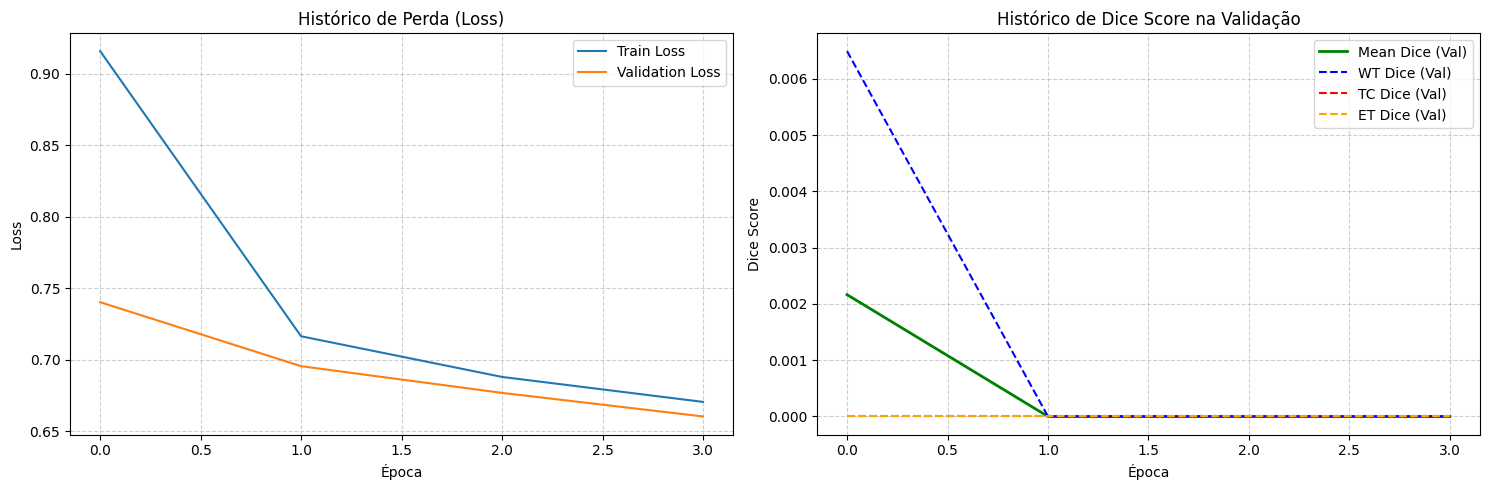

In [ ]:
plot_training_history(history)

In [ ]:
# Definir treinamento para o dataset completo


# Configuração para treinamento completo
full_config = {
    'learning_rate': 0.0001,
    'num_epochs': 30,
    'batch_size': 6,
    'early_stopping_patience': 10,
    'scheduler_patience': 5,
    'scheduler_factor': 0.5
}

# Criar datasets completos
full_train_dataset = BraTSDataset(train_patients, train_patients_data, best_modalities)
full_val_dataset = BraTSDataset(val_patients, train_patients_data, best_modalities)

# Criar DataLoaders completos
full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=full_config['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

full_val_loader = DataLoader(
    full_val_dataset,
    batch_size=full_config['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Configurar novo otimizador e scheduler para treinamento completo
full_optimizer = torch.optim.Adam(model.parameters(), lr=full_config['learning_rate'])
full_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    full_optimizer,
    mode='min',
    factor=full_config['scheduler_factor'],
    patience=full_config['scheduler_patience'],
    verbose=True
)

# Criar gerenciador de treinamento para dataset completo
full_trainer = TrainingManager(
    model=model,
    train_loader=full_train_loader,
    val_loader=full_val_loader,
    criterion=combined_loss_fn,
    optimizer=full_optimizer,
    device=device,
    metrics_calculator=metrics_calculator,
    checkpoint_dir='full_training_checkpoints'
)

print(f"\n✅ CONFIGURAÇÃO COMPLETA:")
print(f"   Dataset de treino: {len(full_train_loader)} batches")
print(f"   Dataset de validação: {len(full_val_loader)} batches")
print(f"   Learning rate: {full_config['learning_rate']}")
print(f"   Épocas planejadas: {full_config['num_epochs']}")
print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")



✅ CONFIGURAÇÃO COMPLETA:
   Dataset de treino: 42 batches
   Dataset de validação: 13 batches
   Learning rate: 0.0001
   Épocas planejadas: 50
   Modalidades: ['T2', 'FLAIR', 'T1CE']


c:\Users\Eduar\OneDrive\Documentos\GitHub\BrainTumor_UNet_Segmentation\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# ⚠️ INICIAR TREINAMENTO
# Descomente a linha abaixo para iniciar o treinamento
# ATENÇÃO: O treinamento pode levar várias horas dependendo da GPU disponível

history = full_trainer.train(
    num_epochs=full_config['num_epochs'],
    scheduler=full_scheduler,
    early_stopping_patience=full_config['early_stopping_patience']
)

# Plotar métricas após o treinamento
plot_training_metrics(history)

Epoch 1 - Training:   0%|          | 0/42 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50 [00:13<?, ?it/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## 8. Inferência e Visualização dos Resultados


In [ ]:
class InferenceEngine:
    """Motor de inferência para segmentação de tumores cerebrais"""

    def __init__(self, model, device, class_names=None):
        self.model = model
        self.device = device
        self.class_names = class_names or ['Background', 'NCR/NET', 'Edema', 'Enhancing']
        self.colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]  # BGR

    def predict(self, input_data):
        """Faz predição em um volume de entrada"""
        self.model.eval()

        with torch.no_grad():
            # Garantir que input_data tenha dimensões corretas
            if input_data.dim() == 4:  # (C, H, W, D) ← CORRETO
                input_data = input_data.unsqueeze(0)  # (1, C, H, W, D)

            # Mover para device
            input_data = input_data.to(self.device)

            # Predição
            outputs = self.model(input_data)

            # Aplicar softmax e obter classes
            probs = F.softmax(outputs, dim=1)
            predictions = torch.argmax(probs, dim=1)

            return predictions.cpu().numpy(), probs.cpu().numpy()

    def visualize_slice(self, input_volume, prediction, ground_truth=None,
                       slice_idx=None, modality_idx=1, figsize=(15, 5)):
        """Visualiza uma fatia específica da segmentação"""

        if slice_idx is None:
            slice_idx = input_volume.shape[-1] // 2  # Fatia central

        # Preparar dados
        input_slice = input_volume[modality_idx, :, :, slice_idx]
        pred_slice = prediction[0, :, :, slice_idx]

        # Configurar subplots
        num_plots = 3 if ground_truth is not None else 2
        fig, axes = plt.subplots(1, num_plots, figsize=figsize)

        # Imagem original
        axes[0].imshow(input_slice, cmap='gray')
        axes[0].set_title(f'Imagem Original (Fatia {slice_idx})')
        axes[0].axis('off')

        # Predição
        axes[1].imshow(input_slice, cmap='gray', alpha=0.7)
        axes[1].imshow(pred_slice, cmap='jet', alpha=0.5)
        axes[1].set_title('Predição')
        axes[1].axis('off')

        # Ground truth (se disponível)
        if ground_truth is not None:
            gt_slice = ground_truth[:, :, slice_idx]
            axes[2].imshow(input_slice, cmap='gray', alpha=0.7)
            axes[2].imshow(gt_slice, cmap='jet', alpha=0.5)
            axes[2].set_title('Ground Truth')
            axes[2].axis('off')

        # Legenda das classes
        legend_elements = [plt.Rectangle((0,0),1,1, color=np.array(self.colors[i])/255)
                          for i in range(len(self.class_names))]
        fig.legend(legend_elements, self.class_names, loc='upper right')

        plt.tight_layout()
        plt.show()

    def visualize_3d_volume(self, prediction, figsize=(12, 8)):
        """Visualiza volume 3D das predições"""
        pred_volume = prediction[0]  # Remover batch dimension

        fig, axes = plt.subplots(2, 3, figsize=figsize)

        # Diferentes vistas (axial, coronal, sagital)
        views = ['Axial', 'Coronal', 'Sagital']

        for class_idx in range(1, 4):  # Excluir background
            class_name = self.class_names[class_idx]

            # Obter máscara da classe
            class_mask = (pred_volume == class_idx)

            # Projeções máximas
            axial_proj = np.max(class_mask, axis=0)
            coronal_proj = np.max(class_mask, axis=1)
            sagital_proj = np.max(class_mask, axis=2)

            # Plotar projeções
            row = (class_idx - 1) // 3
            col = (class_idx - 1) % 3

            axes[row, col].imshow(axial_proj, cmap='hot')
            axes[row, col].set_title(f'{class_name} - Projeção Axial')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    def compute_volume_metrics(self, prediction, ground_truth):
        """Calcula métricas para um volume completo"""
        pred_tensor = torch.from_numpy(prediction).unsqueeze(0)
        gt_tensor = torch.from_numpy(ground_truth).unsqueeze(0)

        # Converter para format one-hot para cálculo de métricas
        pred_one_hot = F.one_hot(pred_tensor.long(), num_classes=4).permute(0, 4, 1, 2, 3).float()

        # Calcular métricas usando nosso calculador
        metrics_calc = SegmentationMetrics(num_classes=4)
        metrics = metrics_calc.compute_all_metrics(pred_one_hot, gt_tensor)

        return metrics

    def save_prediction(self, prediction, output_path, reference_nii_path=None):
        """Salva predição como arquivo NIfTI"""
        # Converter predição para formato adequado
        pred_volume = prediction[0].astype(np.uint8)  # Remover batch dimension

        # Criar imagem NIfTI
        if reference_nii_path:
            # Usar referência para manter metadados
            import nibabel as nib
            ref_img = nib.load(reference_nii_path)
            pred_img = nib.Nifti1Image(pred_volume, ref_img.affine, ref_img.header)
        else:
            pred_img = nib.Nifti1Image(pred_volume, np.eye(4))

        # Salvar
        nib.save(pred_img, output_path)
        print(f"✅ Predição salva em: {output_path}")

# Função para testar inferência com dados de validação
def test_inference(model, val_loader, device, num_samples=3):
    """Testa inferência com amostras do conjunto de validação"""

    # Criar motor de inferência
    inference_engine = InferenceEngine(model, device)

    # Obter algumas amostras
    model.eval()
    with torch.no_grad():
        for i, (data, targets) in enumerate(val_loader):
            if i >= num_samples:
                break

            # Fazer predição
            predictions, probs = inference_engine.predict(data[0])  # Primeiro da batch

            # Visualizar resultados
            print(f"\n Amostra {i+1}:")

            # Calcular métricas
            metrics = inference_engine.compute_volume_metrics(predictions, targets[0].numpy())

            print(f"   Dice Score: {metrics['Dice']['Mean']:.4f}")

            # Visualizar fatia central
            inference_engine.visualize_slice(
                data[0].numpy(),
                predictions,
                targets[0].numpy(),
                slice_idx=None,
                modality_idx=1  # T1ce
            )